#  Машинный перевод с использованием рекуррентных нейронных сетей и механизма внимания

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-seq2seq-model
* https://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-using-attention-with-pytorch/
* http://ethen8181.github.io/machine-learning/deep_learning/seq2seq/2_torch_seq2seq_attention.html
* https://tomekkorbak.com/2020/06/26/implementing-attention-in-pytorch/

## Задачи для совместного разбора

1\. Рассмотрите пример работы `torch.nn.utils.rnn.pad_sequence` для генерации батча.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch as th


class FakeDset(Dataset):
    def __init__(self):
        self.x = [
            th.LongTensor([2, 27, 705, 2327, 5744, 3]),
            th.LongTensor([2, 7, 29, 240, 5669, 2747, 1479, 3]),
            th.LongTensor([2, 27, 705, 2327, 3]),
            th.LongTensor([2, 7, 29, 240, 5669, 2747, 1479, 7, 29, 240, 5669, 3]),
        ]

    def __getitem__(self, idx):
        return (self.x[idx],)

    def __len__(self):
        return len(self.x)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
class Collator:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx  = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        x = [x[0] for x in batch]
        x = pad_sequence(x, batch_first=self.batch_first, padding_value=self.pad_idx)
        return x

In [ ]:
dset = FakeDset()
loader = DataLoader(dset, batch_size=2, collate_fn=Collator(batch_first=True, pad_idx=0) )

In [ ]:
next(iter(loader))

tensor([[   2,   27,  705, 2327, 5744,    3,    0,    0],
        [   2,    7,   29,  240, 5669, 2747, 1479,    3]])

2\. Рассмотрите основные шаги для реализации механизма аддитивного внимания с использованием RNN.

![attention](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2F23YEOESycSImB4FBnFS09C_R18ffuD9luGO4X4cpF4Unqon5-l6fuWwsvottjU_Aj8&usqp=CAU)

$$c_i = \sum_{j=1}^{T_x}\alpha_{ij}h_j$$

$$\alpha_{ij} = \frac{exp(e_{ij})}{\sum_{j=1}^{T_x}exp(e_{ik})}$$

$$ e_{ij} = a(s_{i-1},h_j) = v_a^Ttanh(W_a s_{i-1} + U_a h_j)$$

In [ ]:
batch_size, input_seq_len = 16, 5 # X: 16x5
encoder_hidden_dim = 100
# encoder(x):
encoder_outputs = th.rand(batch_size, input_seq_len, encoder_hidden_dim) # batch_size, input_seq_len, encoder_hidden_dim
encoder_final_hidden = encoder_outputs[:,-1,:].unsqueeze(0) # 1 x batch_size x encoder_hidden_dim

In [ ]:
import torch.nn as nn

decoder_hidden_dim = 100

decoder_input = th.rand(batch_size, encoder_hidden_dim)
decoder_hidden = encoder_final_hidden[0]
rnn = nn.GRUCell(decoder_hidden_dim, encoder_hidden_dim)

rnn(decoder_input, decoder_hidden).shape

torch.Size([16, 100])

In [ ]:
decoder_hidden = encoder_final_hidden
decoder_hidden = decoder_hidden.repeat(input_seq_len, 1, 1).permute(1, 0, 2)
decoder_hidden.shape

torch.Size([16, 5, 100])

In [ ]:
encoder_with_hidden = th.cat((decoder_hidden, encoder_outputs), dim=2)
encoder_with_hidden.shape

torch.Size([16, 5, 200])

In [ ]:
fc1 = nn.Linear(200, decoder_hidden_dim) # proizvl

attn_hidden = fc1(encoder_with_hidden).tanh()
attn_hidden.shape

torch.Size([16, 5, 100])

In [ ]:
fc2 = nn.Linear(decoder_hidden_dim, 1)
energy = fc2(attn_hidden).squeeze(2)
energy.shape

torch.Size([16, 5])

In [ ]:
attn = energy.softmax(dim=1)
attn.shape # веса важности

torch.Size([16, 5])

In [ ]:
attn = attn.unsqueeze(1)
weighted_encoder_outputs = th.bmm(attn, encoder_outputs).squeeze(1)
weighted_encoder_outputs.shape

torch.Size([16, 100])

In [ ]:
decoder_input = th.rand(batch_size, encoder_hidden_dim)

rnn_input = th.cat(
    (decoder_input, weighted_encoder_outputs),
    dim=1
)

In [ ]:
decoder_hidden = encoder_final_hidden[0]
rnn = nn.GRUCell(200, decoder_hidden_dim)
decoder_hidden = rnn(rnn_input, decoder_hidden)
decoder_hidden.shape

torch.Size([16, 100])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте наборы данных для решения задачи машинного перевода на основе файлов `RuBQ_2.0_train.json` (обучающее множество) и `RuBQ_2.0_test.json`. При подготовке набора данных не приводите весь набор данных к одинаковой фиксированной длине. Реализуйте класс `Collator`, который приводит все примеры в батче к одной фиксированной длине, используя `torch.nn.utils.rnn.pad_sequence`. Создайте `DataLoader` с использованием `collate_fn`, получите батч и выведите на экран размер тензоров.

- [ ] Проверено на семинаре

In [1]:
import pandas as pd

train_df = pd.read_json('RuBQ_2.0_train.json')
test_df = pd.read_json('RuBQ_2.0_test.json')

In [2]:
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize

rus_sents = train_df['question_text'].values.tolist()
en_sents = train_df['question_eng'].values.tolist()

rus_sents_test = test_df['question_text'].values.tolist()
en_sents_test = test_df['question_eng'].values.tolist()

def get_corpus(sents):
    corpus = []
    for sent in sents:
      sent = re.sub(r'[^a-zа-я ]', '', sent.lower().strip())
      words = word_tokenize(sent)
      corpus.append(words)
    return corpus

corpus_ru = get_corpus(rus_sents)
corpus_en = get_corpus(en_sents)
corpus_ru_test = get_corpus(rus_sents_test)
corpus_en_test = get_corpus(en_sents_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from torchtext.vocab import build_vocab_from_iterator

ru_vocab = build_vocab_from_iterator(corpus_ru, specials=['<pad>', '<unk>', '<sos>', '<eos>'])
ru_vocab.set_default_index(ru_vocab['<unk>'])
en_vocab = build_vocab_from_iterator(corpus_en, specials=['<pad>', '<unk>', '<sos>', '<eos>'])
en_vocab.set_default_index(en_vocab['<unk>'])

In [4]:
from torch.utils.data import Dataset
import torchtext.transforms as T

class RuEnDataset(Dataset):
    def __init__(self, corpus_ru, corpus_en, ru_vocab, en_vocab):
        self.corpus_ru = corpus_ru
        self.corpus_en = corpus_en
        self.ru_vocab = ru_vocab
        self.en_vocab = en_vocab
        self.trans_ru = T.Sequential(
            T.AddToken('<sos>', begin=True),
            T.AddToken('<eos>', begin=False),
            T.VocabTransform(ru_vocab),
            T.ToTensor(0)
        )
        self.trans_en = T.Sequential(
            T.AddToken('<sos>', begin=True),
            T.AddToken('<eos>', begin=False),
            T.VocabTransform(en_vocab),
            T.ToTensor(0)
        )

    def __getitem__(self, idx):
        a = self.corpus_ru[idx]
        b = self.corpus_en[idx]
        return self.trans_ru(a), self.trans_en(b)

    def __len__(self):
        return len(self.corpus_en)

In [5]:
ru_en_dset = RuEnDataset(corpus_ru, corpus_en, ru_vocab, en_vocab)
ru_en_dset[0]

(tensor([   2,   27,  677, 2206, 5594,    3]),
 tensor([   2,    6,  148,  235,   22, 3980,    3]))

In [6]:
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx  = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        x = [x[0] for x in batch]
        y = [y[1] for y in batch]
        x = pad_sequence(x, batch_first=self.batch_first, padding_value=self.pad_idx)
        y = pad_sequence(y, batch_first=self.batch_first, padding_value=self.pad_idx)
        return x, y

In [7]:
train_dset = RuEnDataset(corpus_ru, corpus_en, ru_vocab, en_vocab)
test_dset = RuEnDataset(corpus_ru_test, corpus_en_test, ru_vocab, en_vocab)

In [8]:
train_dset[0]

(tensor([   2,   27,  677, 2206, 5594,    3]),
 tensor([   2,    6,  148,  235,   22, 3980,    3]))

In [9]:
from torch.utils.data import DataLoader

loader = DataLoader(train_dset, batch_size=128, collate_fn=Collator(batch_first=True, pad_idx=0) )
test_loader = DataLoader(train_dset, batch_size=128, collate_fn=Collator(batch_first=True, pad_idx=0) )

<p class="task" id="2"></p>

2\. Создайте и обучите модель машинного перевода, используя архитектуру Encoder-Decoder на основе RNN с использованием механизма аддитивного внимания. Во время обучения выводите на экран значения функции потерь для эпохи (на обучающем множестве), значение accuracy по токенам (на обучающем множестве) и пример перевода, сгенерированного моделью. После завершения обучения посчитайте BLEU для тестового множества.

- [ ] Проверено на семинаре

In [10]:
import torch.nn as nn
import torch as th

In [107]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
      super().__init__()
      self.emb = nn.Embedding(
          num_embeddings=vocab_size,
          embedding_dim=embedding_dim,
          padding_idx=0
      )
      self.dropout = nn.Dropout(p=0.5)
      self.rnn = nn.GRU(embedding_dim, hidden_size, batch_first=True)

  def forward(self, X):
    out = self.emb(X) # batch x seq x emb_size
    out = self.dropout(out)
    out, h = self.rnn(out) # out: batch x seq x hidden_size
    return out, h # 1 x batch x hidden_size

In [164]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.fc3(th.tanh(self.fc1(query) + self.fc2(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = scores.softmax(dim=-1)
        context = th.bmm(weights, keys)

        return context, weights

class Decoder(nn.Module):
    def __init__(self, n_en_tokens, embedding_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(n_en_tokens, hidden_size)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, n_en_tokens)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        if target_tensor is None:
            decoder_input = th.full((batch_size, 1), 2,  dtype=th.long, device=device)

        seq_len = target_tensor.size(1) if target_tensor is not None else encoder_outputs.size(1)

        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(seq_len):
            if target_tensor is not None:
                # Teacher forcing
                decoder_input = target_tensor[:, i].unsqueeze(1)

            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is None:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

            # if target_tensor is not None:
            #     # Teacher forcing
            #     decoder_input = target_tensor[:, i].unsqueeze(1)
            # else:
            #     # Without teacher forcing
            #     _, topi = decoder_output.topk(1)
            #     decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = th.cat(decoder_outputs, dim=1)
        decoder_outputs = decoder_outputs.log_softmax(dim=-1)
        attentions = th.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.embedding(input)

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = th.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [165]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, X, y=None):

        out, hidden = self.encoder(X)
        outputs = self.decoder(out, hidden, y)

        return outputs

In [166]:
n_ru_tokens = len(ru_vocab.get_stoi())
n_en_tokens = len(en_vocab.get_stoi())
embedding_dim = 350
hidden_size = 200
decoder_hidden_size = 200

device = 'cuda' if th.cuda.is_available() else 'cpu'
encoder = Encoder(n_ru_tokens, embedding_dim, hidden_size)
decoder = Decoder(n_en_tokens, embedding_dim, decoder_hidden_size)
encoder_decoder = EncoderDecoder(encoder, decoder)

for X_, y_ in loader:
    res = encoder_decoder.forward(X_.to(device=device), y_.to(device=device))
    break

In [146]:
!pip install torchmetrics

In [145]:
import torch.optim as optim

In [84]:
import random
import torch.optim as optim
import torchmetrics

In [167]:
n_epochs = 10
lr = 0.001
decoder = Decoder(n_en_tokens, embedding_dim, decoder_hidden_size)
model = EncoderDecoder(encoder, decoder).to(device=device)
crit = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    encoder_decoder.train()
    losses = []
    acc_m = torchmetrics.Accuracy(task='multiclass', num_classes=len(en_vocab.get_stoi()), ignore_index=0)
    for input_tensor, labels in loader:
        optimizer.zero_grad()
        output = encoder_decoder(input_tensor, labels)[0]
        loss = crit(output.reshape(-1, output.size(2)), labels.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss)
        acc_m.update(
            output.reshape(-1, output.size(2)).argmax(dim=1),
            labels.view(-1)
        )

    if (epoch % 5) == 0:
        print('epoch= ', epoch, 'loss= ', loss.item())
        print('accuracy= ', acc_m.compute().item())

        encoder_decoder.eval()
        with th.no_grad():
            example_input = random.choice(train_dset)[0]
            example_output = encoder_decoder(example_input.unsqueeze(0))
            translation = example_output[0].argmax(dim=2).squeeze().tolist()
            print("Оригинал:", ' '.join(ru_vocab.lookup_tokens(example_input.tolist())))
            print("Перевод:", ' '.join(en_vocab.lookup_tokens(translation)))

epoch=  0 loss=  7.907108306884766
accuracy=  0.04846827685832977
Оригинал: <sos> какой город калининградской области до года назывался хайлигенбайль <eos>
Перевод: <sos> <sos> <sos> lothbrok medals enlightener republican ulanude the the
epoch=  5 loss=  7.66527795791626
accuracy=  0.2040581852197647
Оригинал: <sos> какая кислота известна фармацевтам как витамин рр <eos>
Перевод: <sos> <sos> habanera the the the the the the


In [86]:
import warnings
warnings.filterwarnings("ignore")

BLEU_scores = []
for X_b, y_b in test_loader:
  out = model(X_b)[0]
  #out = out.detach()
  out = out.argmax(dim=1)

  y_b = th.flatten(y_b)
  out = th.flatten(out)
  not_pad_ind = (y_b > 0).nonzero(as_tuple=True)[0]
  y_b = y_b[not_pad_ind]
  out = out[not_pad_ind]
  hypothesis = y_b.tolist()
  reference = out.tolist()
  hypothesis = en_vocab.lookup_tokens(hypothesis)
  reference = en_vocab.lookup_tokens(reference)
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
  BLEU_scores.append(BLEUscore)
print(f'BLEU = {th.tensor(BLEU_scores).mean().item():.3f}')

BLEU = 0.004


<p class="task" id="3"></p>

3\. Сгенерируйте перевод при помощи обученной модели и визуализируйте матрицу внимания, в которой отображено, на какие слова из исходного предложения модель обращала внимание при генерации очередного слова в переводе.

- [ ] Проверено на семинаре

In [95]:
example_input, ans = random.choice(train_dset)
example_output = encoder_decoder(example_input.unsqueeze(0))
translation = example_output[0].argmax(dim=2).squeeze().tolist()
print("Оригинал:", ' '.join(ru_vocab.lookup_tokens(example_input.tolist())))
print("Перевод:", ' '.join(en_vocab.lookup_tokens(translation)))

Оригинал: <sos> сколько звезд на флаге венесуэлы <eos>
Перевод: pauper andnotre golden the the the the


In [96]:
attn_lst = model(x)[2]
attn = attn_lst.squeeze().detach()

In [99]:
words_ru = ru_vocab.lookup_tokens(example_input.tolist())
words_en = en_vocab.lookup_tokens(translation)
words_en

['pauper', 'andnotre', 'golden', 'the', 'the', 'the', 'the']

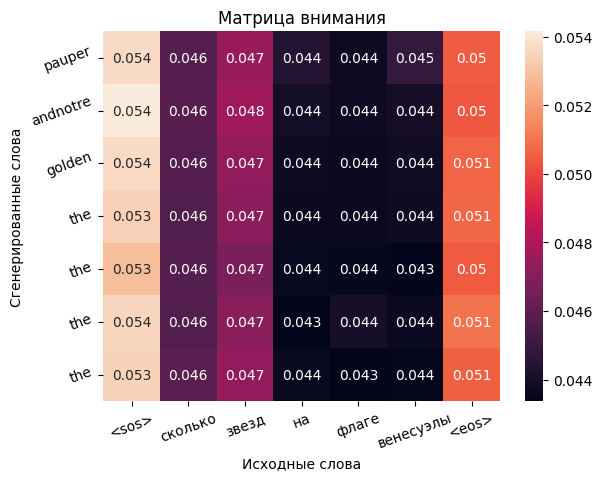

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(attn[1:len(words_ru)+1, 1:len(words_en)+1], annot=True)
plt.xlabel('Исходные слова')
plt.yticks(th.arange(0.5, len(words_en)+0.5), words_en, rotation=20)
plt.xticks(th.arange(0.5, len(words_ru)+0.5), words_ru, rotation=20)
plt.ylabel('Сгенерированные слова')
plt.title('Матрица внимания')
plt.show()

## Обратная связь
- [x] Хочу получить обратную связь по решению